* Nama : Rizky Adhi Nugroho
* Domisili : Tangerang Selatan
* email : nugrohorizkyadhi@gmail.com

In [ ]:
#cek versi tensorflow
import tensorflow as tf
print(tf.__version__)

2.6.0


import dataset dari drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


ekstrak zip

In [ ]:
!unzip /content/drive/MyDrive/catdogwild.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/flickr_wild_001396.jpg  
  inflating: afhq/train/wild/flickr_wild_001399.jpg  
  inflating: afhq/train/wild/flickr_wild_001400.jpg  
  inflating: afhq/train/wild/flickr_wild_001401.jpg  
  inflating: afhq/train

menentukan Base direktori, cek jumlah file

In [ ]:
import os
 #lokasi direktori dasar
dir_base ='/content/afhq/train'
os.listdir(dir_base)
print(os.listdir(dir_base))

#hitung jumlah file per direktori
cat = len(os.listdir('/content/afhq/train/cat')) 
dog = len(os.listdir('/content/afhq/train/dog')) 
wild = len(os.listdir('/content/afhq/train/wild'))
print ("jumlah foto guguk:", dog, ", jumlah foto meong:", cat, ", jumlah foto liar:", wild)
print("jumlah total dataset:", dog + cat + wild )

['dog', 'cat', 'wild']
jumlah foto guguk: 4740 , jumlah foto meong: 5154 , jumlah foto liar: 4738
jumlah total dataset: 14632


cek resolusi gambar

In [ ]:
import cv2
img = cv2.imread('/content/afhq/train/cat/flickr_cat_000001.jpg', cv2.IMREAD_UNCHANGED)
img1 = cv2.imread('/content/afhq/val/cat/flickr_cat_000008.jpg', cv2.IMREAD_UNCHANGED) 
print('Original Dimensions : ',img.shape, img1.shape) #resolusi berbeda

Original Dimensions :  (374, 500, 3) (512, 512, 3)


image data generator dan split data dengan 80 20

In [ ]:
#augmentasi gambar
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'wrap',
                    validation_split=0.2
                    )

In [ ]:
train_generator = train_datagen.flow_from_directory(
        dir_base, # direktori data base
        target_size=(150, 100),  # mengubah resolusi seluruh gambar menjadi 150x100 piksel
        batch_size=4,
        subset='training',
        # klasifikasi > 2 kelas maka menggunakan class_mode = 'categorical'
        class_mode='categorical'
        
        )
 
validation_generator = train_datagen.flow_from_directory(
        dir_base, # direktori data base
        target_size=(150, 100), # mengubah resolusi seluruh gambar menjadi 150x100 piksel
        batch_size=4,
        subset='validation', 
        # klasifikasi > 2 kelas maka menggunakan class_mode = 'categorical'
        class_mode='categorical'
        )

Found 11707 images belonging to 3 classes.
Found 2925 images belonging to 3 classes.


buat arsitektur model

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2

model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 100, 3))),
    tf.keras.layers.Conv2D(56, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.layers[0].trainable = False
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 5, 4, 2048)        58331648  
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 2, 56)          1032248   
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 1, 1, 56)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               29184     
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 1539      
Total params: 59,394,619
Trainable params: 1,062,971
Non-trainable params: 58,331,648
__________________________________

In [ ]:
from tensorflow.keras.optimizers import RMSprop
# compile model dengan 'adam' optimizer loss function 'categorical_crossentropy' 
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

membuat callback

In [ ]:
#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.977 and logs.get('val_accuracy')>0.97):
      print("\n akurasi telah mencapai >97%!")
      self.model.stop_training = True
callbacks = myCallback()

latih model

In [ ]:
# latih model dengan model.fit 
history = model.fit(
      train_generator,
      steps_per_epoch=12,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs= 20, # tambahkan eposchs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2,
      callbacks=[callbacks]
      )

Epoch 1/20
12/12 - 26s - loss: 1.1135 - accuracy: 0.8542 - val_loss: 0.9541 - val_accuracy: 0.9500
Epoch 2/20
12/12 - 12s - loss: 0.8629 - accuracy: 0.9167 - val_loss: 0.9629 - val_accuracy: 0.8000
Epoch 3/20
12/12 - 11s - loss: 0.9993 - accuracy: 0.8750 - val_loss: 2.0302 - val_accuracy: 0.7000
Epoch 4/20
12/12 - 11s - loss: 0.3392 - accuracy: 0.9792 - val_loss: 0.2266 - val_accuracy: 0.9000
Epoch 5/20
12/12 - 11s - loss: 0.2363 - accuracy: 0.9167 - val_loss: 0.2736 - val_accuracy: 0.9000
Epoch 6/20
12/12 - 11s - loss: 0.0395 - accuracy: 0.9792 - val_loss: 1.1989 - val_accuracy: 0.8000
Epoch 7/20
12/12 - 11s - loss: 0.7238 - accuracy: 0.9583 - val_loss: 0.5237 - val_accuracy: 0.9000
Epoch 8/20
12/12 - 11s - loss: 0.3001 - accuracy: 0.9167 - val_loss: 0.4643 - val_accuracy: 0.9000
Epoch 9/20
12/12 - 12s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.8722 - val_accuracy: 0.8000
Epoch 10/20
12/12 - 12s - loss: 0.8969 - accuracy: 0.8958 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 11/

Saving flickr_cat_000003.jpg to flickr_cat_000003.jpg
flickr_cat_000003.jpg
meong


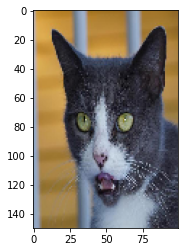

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,100))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes[0][0]==1:
    print('guguk')
  elif classes[0][1]==1:
    print('meong')
  elif classes[0][2]==1:
    print('liar')

plot akurasi dan loss

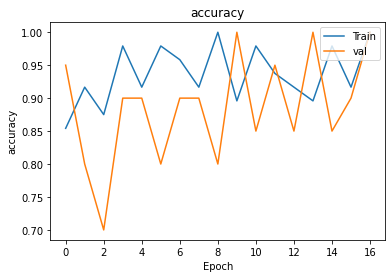

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper right')
plt.show()

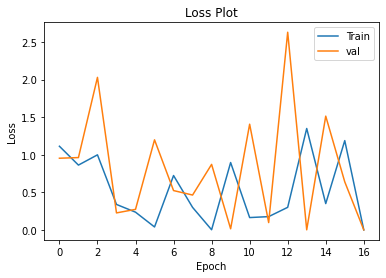

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper right')
plt.show()

konversi model

In [ ]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpjh6z0rdb/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
